## Problem description

## Data gathering and storage

![title](img/responses.jpg)

![title](img/credits.jpg)

In [1]:
import tmdbsimple as tmdb
import time
from requests import HTTPError

tmdb.API_KEY = '34ed3ca4d3adae63d1bed1b1598bfbbb'

In [2]:
import sys
from pymongo import MongoClient
import json

client = MongoClient('localhost', 27017, username='mongoadmin', password='pass1234')
database = client['bda']

In [ ]:
movies = database.movies
discover_search = tmdb.Discover()

max_retries = 3


for year in reversed(range(1950, 2021)):
    start = time.time()
    print("Retrieving movies for year {0}...".format(year))
    info_results = discover_search.movie(page=1, primary_release_year=year)
    
    for page in range(1, info_results['total_pages'] + 1):
        response = discover_search.movie(page=page, primary_release_year=year)['results']
        movies_with_credits = []
        for entry in response:
            for retry in range(max_retries):
                try:
                    movies_search = tmdb.Movies(id=entry['id'])
                    credits = movies_search.credits()
                    entry['count_cast_gender_0'] = 0
                    entry['count_cast_gender_1'] = 0
                    entry['count_cast_gender_2'] = 0
                    for cast_member in credits['cast']:
                        if cast_member['gender'] == 1:
                            entry['count_cast_gender_1'] += 1
                        elif cast_member['gender'] == 2:
                            entry['count_cast_gender_2'] += 1
                        else:
                            entry['count_cast_gender_0'] += 1
                    movies_with_credits.append(entry)
                    break
                except HTTPError as e:
                    if e.response.status_code in [404, 401] :
                        break
                    if e.response.status_code in [500, 502, 503, 504] :
                        print("{0}: retry {1}".format(e.response.status_code, retry + 1))
                        time.sleep(retry**2)
                        pass
                    else:
                        raise
        if len(movies_with_credits) > 0:
            movies.insert_many(movies_with_credits)
    
    end = time.time()
    print("Done in {0} minutes".format((end - start) // 60))


Retrieving movies for year 2020...
Done in 19.0 minutes
Retrieving movies for year 2019...
Done in 17.0 minutes
Retrieving movies for year 2018...
Done in 31.0 minutes
Retrieving movies for year 2017...
Done in 32.0 minutes
Retrieving movies for year 2016...
Done in 32.0 minutes
Retrieving movies for year 2015...
Done in 32.0 minutes
Retrieving movies for year 2014...
Done in 32.0 minutes
Retrieving movies for year 2013...
Done in 32.0 minutes
Retrieving movies for year 2012...
Done in 31.0 minutes
Retrieving movies for year 2011...
Done in 31.0 minutes
Retrieving movies for year 2010...
Done in 31.0 minutes
Retrieving movies for year 2009...
Done in 32.0 minutes
Retrieving movies for year 2008...
Done in 37.0 minutes
Retrieving movies for year 2007...
502: retry 1
502: retry 2
502: retry 3
502: retry 1
502: retry 2
502: retry 3
502: retry 1
502: retry 2
502: retry 3
502: retry 1
502: retry 2
502: retry 3
502: retry 1
502: retry 2
502: retry 3
502: retry 1
502: retry 2
502: retry 3
Don

In [ ]:
#movies.remove({})
movies.count_documents({})

In [ ]:
genres = database.genres
tmdb.API_KEY = '34ed3ca4d3adae63d1bed1b1598bfbbb'
search = tmdb.Genres()
response = search.movie_list(page=page,primary_release_year=year)['genres']
genres.insert_many(response)

In [ ]:
#genres.remove({})
genres.count_documents({})

## Data description

In [14]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017, username='mongoadmin', password='pass1234')
database = client['bda']

We can actually omit some fields, and we do so before loading the dataset

In [10]:
import pandas as pd

movies = database.movies
cursor = movies.find({},{ 'adult': 0, 'backdrop_path': 0, 'original_title': 0, 'overview': 0, 'poster_path': 0, 'video': 0, '_id': 0 })
moviesdf = pd.DataFrame(list(cursor))

We first want to get a broad view of the dataset

In [11]:
moviesdf.head()

,genre_ids,id,original_language,popularity,release_date,title,vote_average,vote_count,count_cast_gender_0,count_cast_gender_1,count_cast_gender_2
0,"[12, 14, 10751, 16]",529203,en,2712.592,2020-11-25,The Croods: A New Age,8.1,464,0,6,6
1,"[28, 53, 80, 18]",553604,en,2431.379,2020-09-03,Honest Thief,7.0,244,5,2,8
2,"[28, 53, 878]",577922,en,2050.348,2020-08-22,Tenet,7.4,3120,19,5,21
3,"[53, 80, 9648]",646593,en,1604.624,2020-12-04,Wander,5.6,38,5,6,5
4,"[28, 53]",524047,en,1420.677,2020-07-29,Greenland,7.2,1031,3,8,13


We also see below how the dataset doesn't contain null values in any column

In [37]:
moviesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324297 entries, 0 to 324560
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   genre_ids            324297 non-null  object        
 1   id                   324297 non-null  int64         
 2   original_language    324297 non-null  object        
 3   popularity           324297 non-null  float64       
 4   release_date         324297 non-null  datetime64[ns]
 5   title                324297 non-null  object        
 6   vote_average         324297 non-null  float64       
 7   vote_count           324297 non-null  int64         
 8   count_cast_gender_0  324297 non-null  int64         
 9   count_cast_gender_1  324297 non-null  int64         
 10  count_cast_gender_2  324297 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 29.7+ MB


In [19]:
moviesdf.isna().sum()

genre_ids              0
id                     0
original_language      0
popularity             0
release_date           0
title                  0
vote_average           0
vote_count             0
count_cast_gender_0    0
count_cast_gender_1    0
count_cast_gender_2    0
dtype: int64

## Data cleaning

Are there duplicates? To check this we use the id field, since we actually have to consider the case of movies with the same name.

In [26]:
moviesdf[moviesdf.duplicated(['id'])]

,genre_ids,id,original_language,popularity,release_date,title,vote_average,vote_count,count_cast_gender_0,count_cast_gender_1,count_cast_gender_2
21701,"[80, 28, 10749]",534134,en,4.497,2018-09-24,Blackbird,6.5,4,2,1,3
61871,"[12, 10751]",285191,no,3.283,2014-09-26,Captain Sabertooth and the Treasure of Lama Rama,5.4,24,0,3,13
124770,"[35, 18]",82956,de,0.883,2008-09-28,Die Schimmelreiter,5.0,1,12,5,14
297678,"[878, 14]",696457,ja,0.600,1972-07-22,Mirror Man: Dinosaur Aroza Reanimated,0.0,0,0,1,1
297718,[35],686310,el,0.600,1972-01-10,Πώς Καταντήσαμε Σωτήρη!..,5.0,1,12,6,8
...,...,...,...,...,...,...,...,...,...,...,...
308295,[],580473,de,0.600,1969-03-07,Metermass Kaputt,0.0,0,0,0,0
308429,"[18, 10770]",537409,ru,0.600,1969-11-08,Вальс,6.0,1,1,6,5
308503,[18],519055,el,0.600,1969-10-07,Refugee Girl on the Run,4.0,1,1,1,6
308540,"[18, 10752]",508263,az,0.600,1969-10-30,Shared Bread,8.5,2,13,4,9


Let's remove these duplicates

In [31]:
moviesdf = moviesdf.drop_duplicates(subset=['id'])

The given release date is in string format, so we need to change this in datetime format

In [36]:
moviesdf['release_date'] = pd.to_datetime(moviesdf['release_date'])

<ipython-input-36-873a53e439ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf['release_date'] = pd.to_datetime(moviesdf['release_date'])


## Data analysis
## Conclusions

How many cast member have *gender=0*?

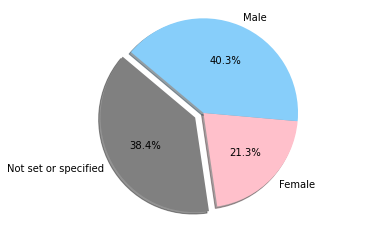

In [13]:
import matplotlib.pyplot as plt

# Data to plot
labels = 'Not set or specified', 'Female', 'Male'
sizes = [
    moviesdf.count_cast_gender_0.sum(),
    moviesdf.count_cast_gender_1.sum(),
    moviesdf.count_cast_gender_2.sum()]
colors = ['grey', 'pink', 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

We have a look at the movies with highest amount of cast member with unspecified gender

In [8]:
moviesdf.sort_values(by=['count_cast_gender_0'], ascending=False).head()

,genre_ids,id,original_language,popularity,release_date,title,vote_average,vote_count,count_cast_gender_0,count_cast_gender_1,count_cast_gender_2
129982,"[35, 10751, 14, 10749]",4523,en,32.611,2007-11-20,Enchanted,6.7,4048,192,32,25
20154,"[35, 10749]",458423,en,20.656,2018-07-09,Mamma Mia! Here We Go Again,7.2,2466,163,35,28
113383,[36],36400,pl,1.215,2009-02-27,Popieluszko: Freedom Is Within Us,6.1,9,161,7,15
167125,"[10752, 18, 28, 12, 36]",10105,en,9.552,2003-09-11,Saints and Soldiers,6.3,171,153,0,11
10420,"[99, 10402]",593691,en,14.666,2019-04-17,Homecoming: A Film by Beyoncé,8.3,247,146,12,5
